# **Avalanche Risk Project**

Advanced Data Analytics, Fall 2025

The following project examines the feasibility of deep learning models (3D-CNN, convLSTM) compared to traditional, state-of-the-art methods for predicting avalanche danger levels. Using a comprehensive dataset from the Swiss Federal Institute for Snow and Avalanche Research (SLF) spanning from 1997-2020, the project heavily relies on the work of Pérez-Guillén et al. (2022) and Maissen et al. (2024) and adopts many of their preprocessing and modeling techniques.

In [2]:
import requests
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

## **2. Exploratory Data Analysis (EDA)**

In [3]:
imis_df = pd.read_csv('data/imis_df_cleaned.csv')

In [4]:
imis_df

,datum,station_code,sector_id,warnreg,elevation_station,forecast_initial_date,forecast_end_date,dangerLevel,elevation_th,set,...,ccl_pwl,ssi_pwl_100,sk38_pwl_100,sn38_pwl_100,ccl_pwl_100,Pen_depth,min_ccl_pen,lon,lat,delta_elevation
0,2019-11-15,ALB2,5231.0,21.0,2300.0,2019-11-15 17:00:00,2019-11-16 17:00:00,3.0,2200.0,test,...,0.25,1.61,0.61,0.98,0.25,34.402762,0.18,9.836224,46.580945,100.0
1,2019-11-16,ALB2,5231.0,21.0,2300.0,2019-11-16 17:00:00,2019-11-17 17:00:00,3.0,2200.0,test,...,0.28,1.76,0.76,1.05,0.28,35.092922,0.20,9.836224,46.580945,100.0
2,2019-11-17,ALB2,5231.0,21.0,2300.0,2019-11-17 17:00:00,2019-11-18 17:00:00,3.0,2000.0,test,...,0.34,0.94,0.85,1.08,0.34,26.587603,0.23,9.836224,46.580945,300.0
3,2019-11-18,ALB2,5231.0,21.0,2300.0,2019-11-18 17:00:00,2019-11-19 17:00:00,3.0,2200.0,test,...,0.40,1.93,0.93,1.19,0.40,22.648569,0.30,9.836224,46.580945,100.0
4,2019-11-19,ALB2,5231.0,21.0,2300.0,2019-11-19 17:00:00,2019-11-20 17:00:00,3.0,2200.0,test,...,0.43,2.01,1.01,1.28,0.43,21.163923,0.32,9.836224,46.580945,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291866,2020-04-29,ZNZ2,7123.0,21.0,2700.0,2020-04-29 17:00:00,2020-04-30 17:00:00,2.0,2400.0,test,...,4.00,6.00,6.00,6.00,4.00,10.363926,1.08,10.018844,46.697716,300.0
291867,2020-04-30,ZNZ2,7123.0,21.0,2700.0,2020-04-30 17:00:00,2020-05-01 17:00:00,2.0,2400.0,test,...,4.00,6.00,6.00,6.00,4.00,13.866200,0.38,10.018844,46.697716,300.0
291868,2020-05-01,ZNZ2,7123.0,21.0,2700.0,2020-05-01 17:00:00,2020-05-02 17:00:00,2.0,2400.0,test,...,4.00,6.00,6.00,6.00,4.00,14.396211,0.36,10.018844,46.697716,300.0
291869,2020-05-02,ZNZ2,7123.0,21.0,2700.0,2020-05-02 17:00:00,2020-05-03 17:00:00,2.0,2400.0,test,...,4.00,6.00,6.00,6.00,4.00,16.123371,0.35,10.018844,46.697716,300.0


### **2.1 Target Variable Analysis**

We start with a temporal and spatial analysis of the target variable, `dangerLevel`, to understand its distribution across different stations and over time.

In [ ]:
# Convert datum to datetime
imis_df['datum'] = pd.to_datetime(imis_df['datum'])
imis_df['month'] = imis_df['datum'].dt.month
imis_df['year'] = imis_df['datum'].dt.year

avalanche_season = imis_df[imis_df['month'].isin([11, 12, 1, 2, 3, 4, 5])].copy()

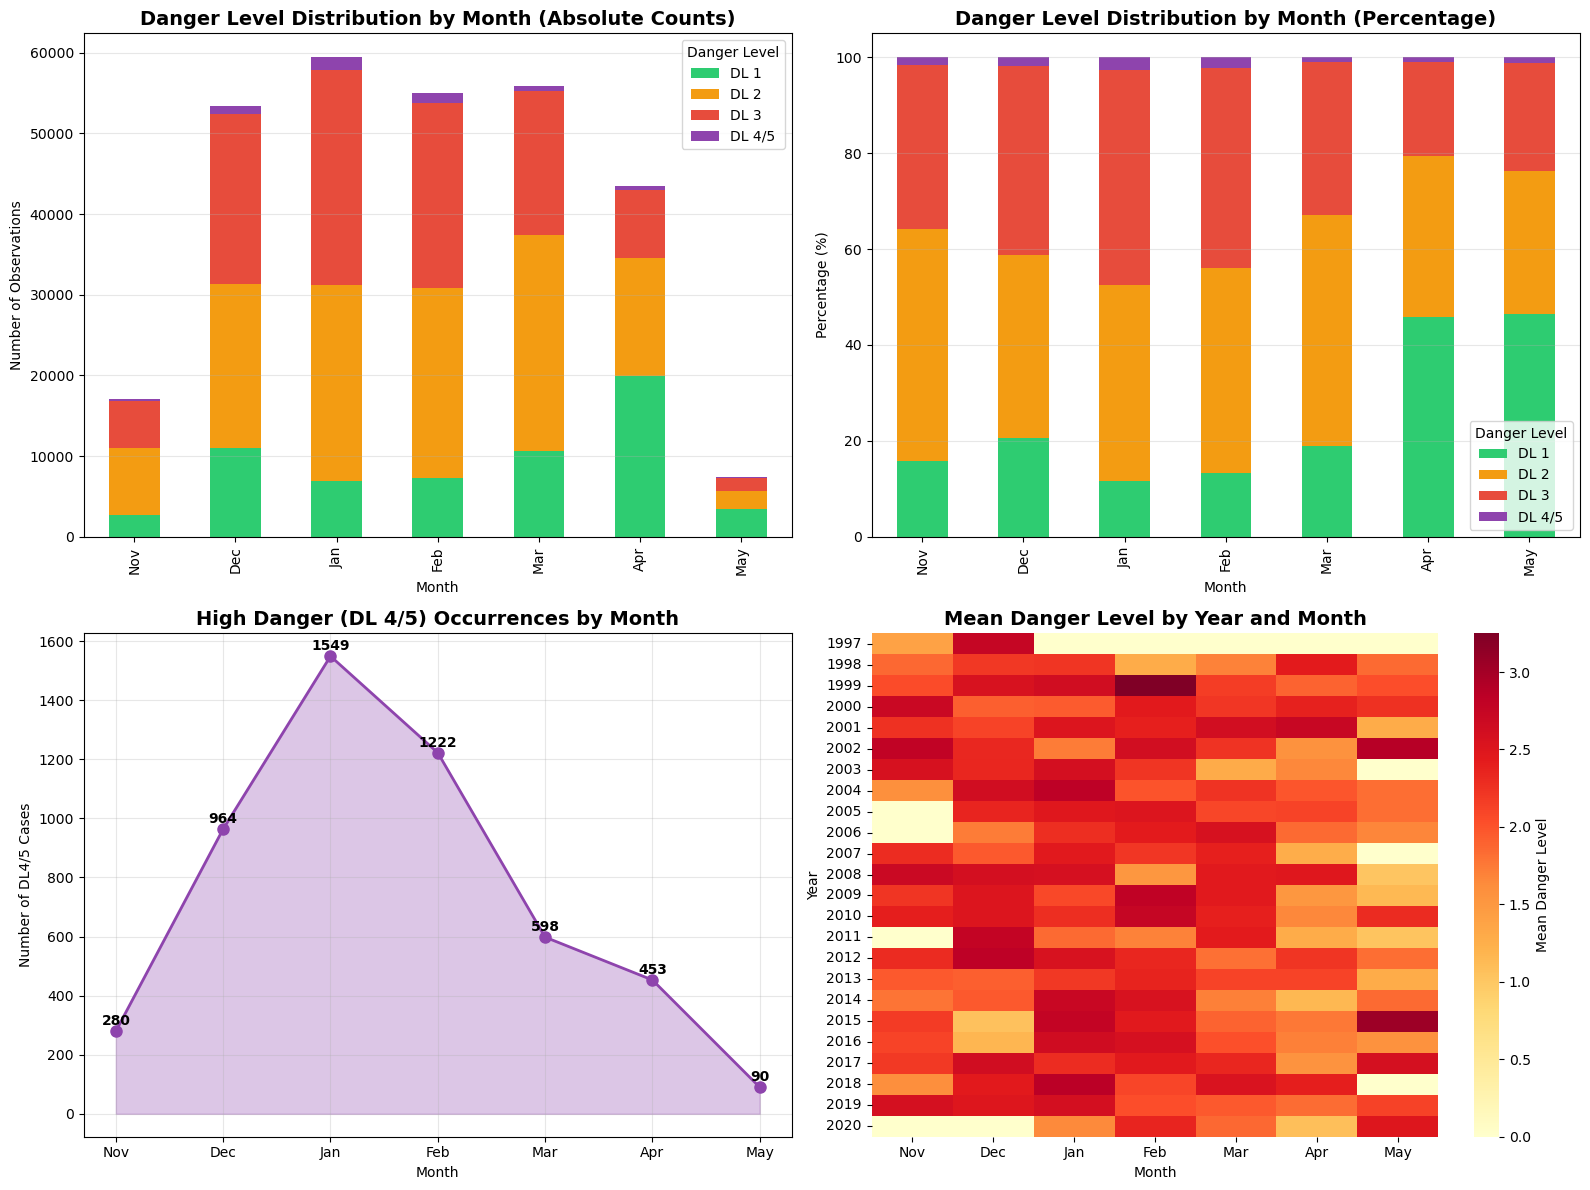

In [15]:
# Monthly Danger Level Distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Absolute Counts
monthly_counts = avalanche_season.groupby(['month', 'dangerLevel']).size().unstack(fill_value=0)
month_names = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
monthly_counts.index = monthly_counts.index.map({11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 
                                                   3: 'Mar', 4: 'Apr', 5: 'May'})
monthly_counts = monthly_counts.reindex(month_names)

monthly_counts.plot(kind='bar', stacked=True, ax=axes[0, 0], 
                    color=['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad'])
axes[0, 0].set_title('Danger Level Distribution by Month (Absolute Counts)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Observations')
axes[0, 0].legend(title='Danger Level', labels=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
axes[0, 0].grid(axis='y', alpha=0.3)

# Percentages
monthly_pct = avalanche_season.groupby(['month', 'dangerLevel']).size().unstack(fill_value=0)
monthly_pct = monthly_pct.div(monthly_pct.sum(axis=1), axis=0) * 100
monthly_pct.index = monthly_pct.index.map({11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 
                                            3: 'Mar', 4: 'Apr', 5: 'May'})
monthly_pct = monthly_pct.reindex(month_names)

monthly_pct.plot(kind='bar', stacked=True, ax=axes[0, 1],
                 color=['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad'])
axes[0, 1].set_title('Danger Level Distribution by Month (Percentage)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].legend(title='Danger Level', labels=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
axes[0, 1].grid(axis='y', alpha=0.3)

# Line Plot - Danger Level 4 Ocurrences
dl4_by_month = avalanche_season[avalanche_season['dangerLevel'] == 4].groupby('month').size()
dl4_by_month.index = dl4_by_month.index.map({11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 
                                               3: 'Mar', 4: 'Apr', 5: 'May'})
dl4_by_month = dl4_by_month.reindex(month_names, fill_value=0)

axes[1, 0].plot(dl4_by_month.index, dl4_by_month.values, marker='o', 
                linewidth=2, markersize=8, color='#8e44ad')
axes[1, 0].fill_between(range(len(month_names)), dl4_by_month.values, alpha=0.3, color='#8e44ad')
axes[1, 0].set_title('High Danger (DL 4/5) Occurrences by Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of DL4/5 Cases')
axes[1, 0].grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(dl4_by_month.values):
    axes[1, 0].text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

# Heatmap - Danger Level by month and year
yearly_monthly = avalanche_season.groupby(['year', 'month'])['dangerLevel'].mean().unstack(fill_value=0)
yearly_monthly.columns = yearly_monthly.columns.map({11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 
                                                       3: 'Mar', 4: 'Apr', 5: 'May'})
yearly_monthly = yearly_monthly[month_names]

sns.heatmap(yearly_monthly, cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Mean Danger Level'})
axes[1, 1].set_title('Mean Danger Level by Year and Month', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Year')

plt.tight_layout()
plt.show()

Based on the visualization provided, here's a brief analysis of the avalanche danger level distribution:

- Seasonal Peak: High danger levels (DL 4/5) peak significantly in January (1549 cases) and February (1222 cases), aligning with peak winter conditions. This confirms that any validation set must include these months to properly test a model's ability to predict high danger.

- Shoulder Seasons: November and May have very few high-danger cases, dominated instead by lower danger levels (DL 1/2). This suggests different meteorological drivers in early/late season compared to mid-winter.

- Yearly Variability: The heatmap (bottom right) shows clear inter-annual variability. Some years (e.g., 1999, 2018) had intense, prolonged high-danger periods (dark red), while others (e.g., 2011, 2020) were notably milder (lighter colors). A robust model will need to capture these broad seasonal trends.

- Dominant Classes: Throughout the core winter (Dec-Mar), Danger Level 3 (Considerable, red) and Danger Level 2 (Moderate, orange) consistently make up the vast majority of all forecasts, reinforcing the class imbalance challenge.

In [16]:
# Get SLF warning area boundaries
import requests

# Replace with the actual base URL found at the top of your Swagger page
BASE_URL = "https://aws.slf.ch/api/warningregion/#" 
ENDPOINT = "/warnregionDefinition/findByDate/geojson"

def get_warn_regions_geojson(date_str):
    """
    Fetches warn region GeoJSON for a specific date.
    date_str must be in 'YYYY-MM-DD' format.
    """
    url = f"{BASE_URL}{ENDPOINT}"
    params = {"date": date_str}
    headers = {"Accept": "application/json"}

    try:
        response = requests.get(url, params=params, headers=headers)
        response.raise_for_status() # Raises error for 4xx/5xx
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {date_str}: {e}")
        return None

# Example Usage:
geojson_data = get_warn_regions_geojson("2020-01-15")

if geojson_data:
    # You can then load this directly into GeoPandas
    import geopandas as gpd
    gdf_regions = gpd.GeoDataFrame.from_features(geojson_data["features"])
    print(gdf_regions.head())

Error fetching data for 2020-01-15: Expecting value: line 2 column 1 (char 1)


✅ SLF boundaries loaded: 149 warning regions
   CRS: EPSG:4326

Columns: ['id', 'sector_id', 'sector_name', 'warnregion_def_id', 'geometry']

First few regions:
     id sector_id           sector_name  warnregion_def_id  \
0  1111      1111  Waadtländer Voralpen                 21   
1  1112      1112         Pays d'Enhaut                 21   
2  1113      1113          Aigle-Leysin                 21   
3  1114      1114           Bex-Villars                 21   
4  1121      1121                  Jaun                 21   

                                            geometry  
0  POLYGON ((6.97352 46.44584, 6.97448 46.43707, ...  
1  POLYGON ((7.1934 46.37874, 7.12036 46.39255, 7...  
2  POLYGON ((6.92374 46.39781, 6.98754 46.40001, ...  
3  POLYGON ((7.08365 46.18396, 7.08654 46.15919, ...  
4  POLYGON ((6.98407 46.53648, 6.98964 46.54962, ...  


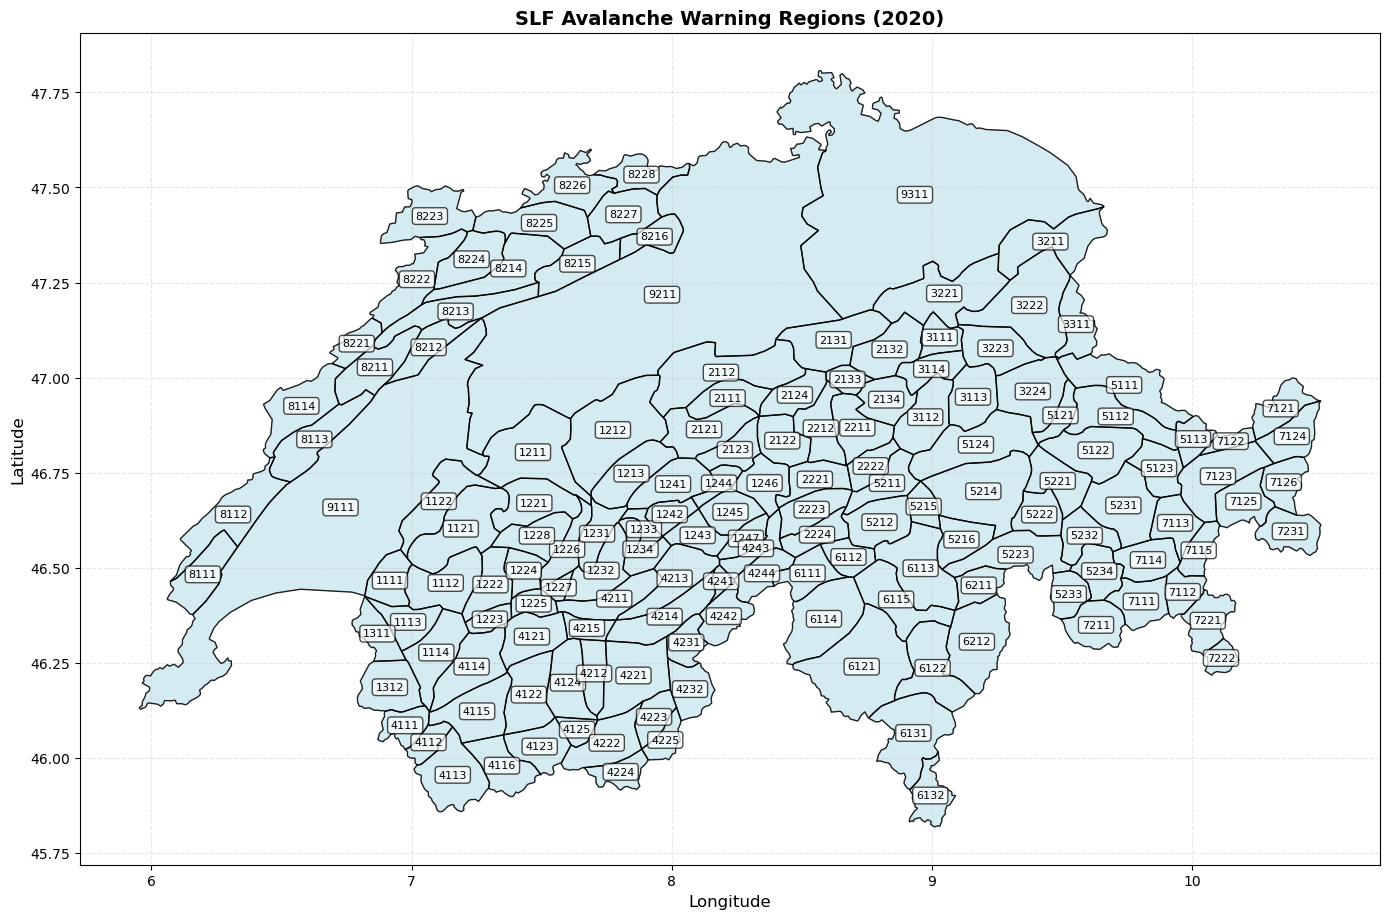


📊 Total warning regions: 149
Coordinate bounds:
  Longitude: [5.95, 10.49]
  Latitude:  [45.82, 47.81]


In [19]:
# Plot SLF warning region boundaries
slf_bounds = gpd.read_file('data/slf_boundaries_2020.json')

print(f"✅ SLF boundaries loaded: {len(slf_bounds)} warning regions")
print(f"   CRS: {slf_bounds.crs}")
print(f"\nColumns: {slf_bounds.columns.tolist()}")
print(f"\nFirst few regions:")
print(slf_bounds.head())

# Ensure correct CRS
if slf_bounds.crs != 'EPSG:4326':
    slf_bounds = slf_bounds.to_crs('EPSG:4326')
    print("   Reprojected to EPSG:4326")

# Create the plot
fig, ax = plt.subplots(figsize=(14, 12))

# Plot boundaries
slf_bounds.boundary.plot(ax=ax, color='black', linewidth=1, alpha=0.8)
slf_bounds.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.5, alpha=0.5)

# Add labels if there's a region name column
if 'id' in slf_bounds.columns or 'name' in slf_bounds.columns:
    for idx, row in slf_bounds.iterrows():
        centroid = row.geometry.centroid
        label = row.get('id', row.get('name', idx))
        ax.text(centroid.x, centroid.y, str(label), 
                fontsize=8, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_title('SLF Avalanche Warning Regions (2020)', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Show summary statistics
print(f"\n📊 Total warning regions: {len(slf_bounds)}")
print(f"Coordinate bounds:")
print(f"  Longitude: [{slf_bounds.total_bounds[0]:.2f}, {slf_bounds.total_bounds[2]:.2f}]")
print(f"  Latitude:  [{slf_bounds.total_bounds[1]:.2f}, {slf_bounds.total_bounds[3]:.2f}]")

✅ Swiss boundaries loaded: 6674 features
   CRS: EPSG:2056
   Reprojected to EPSG:4326

Total stations with coordinates: 130


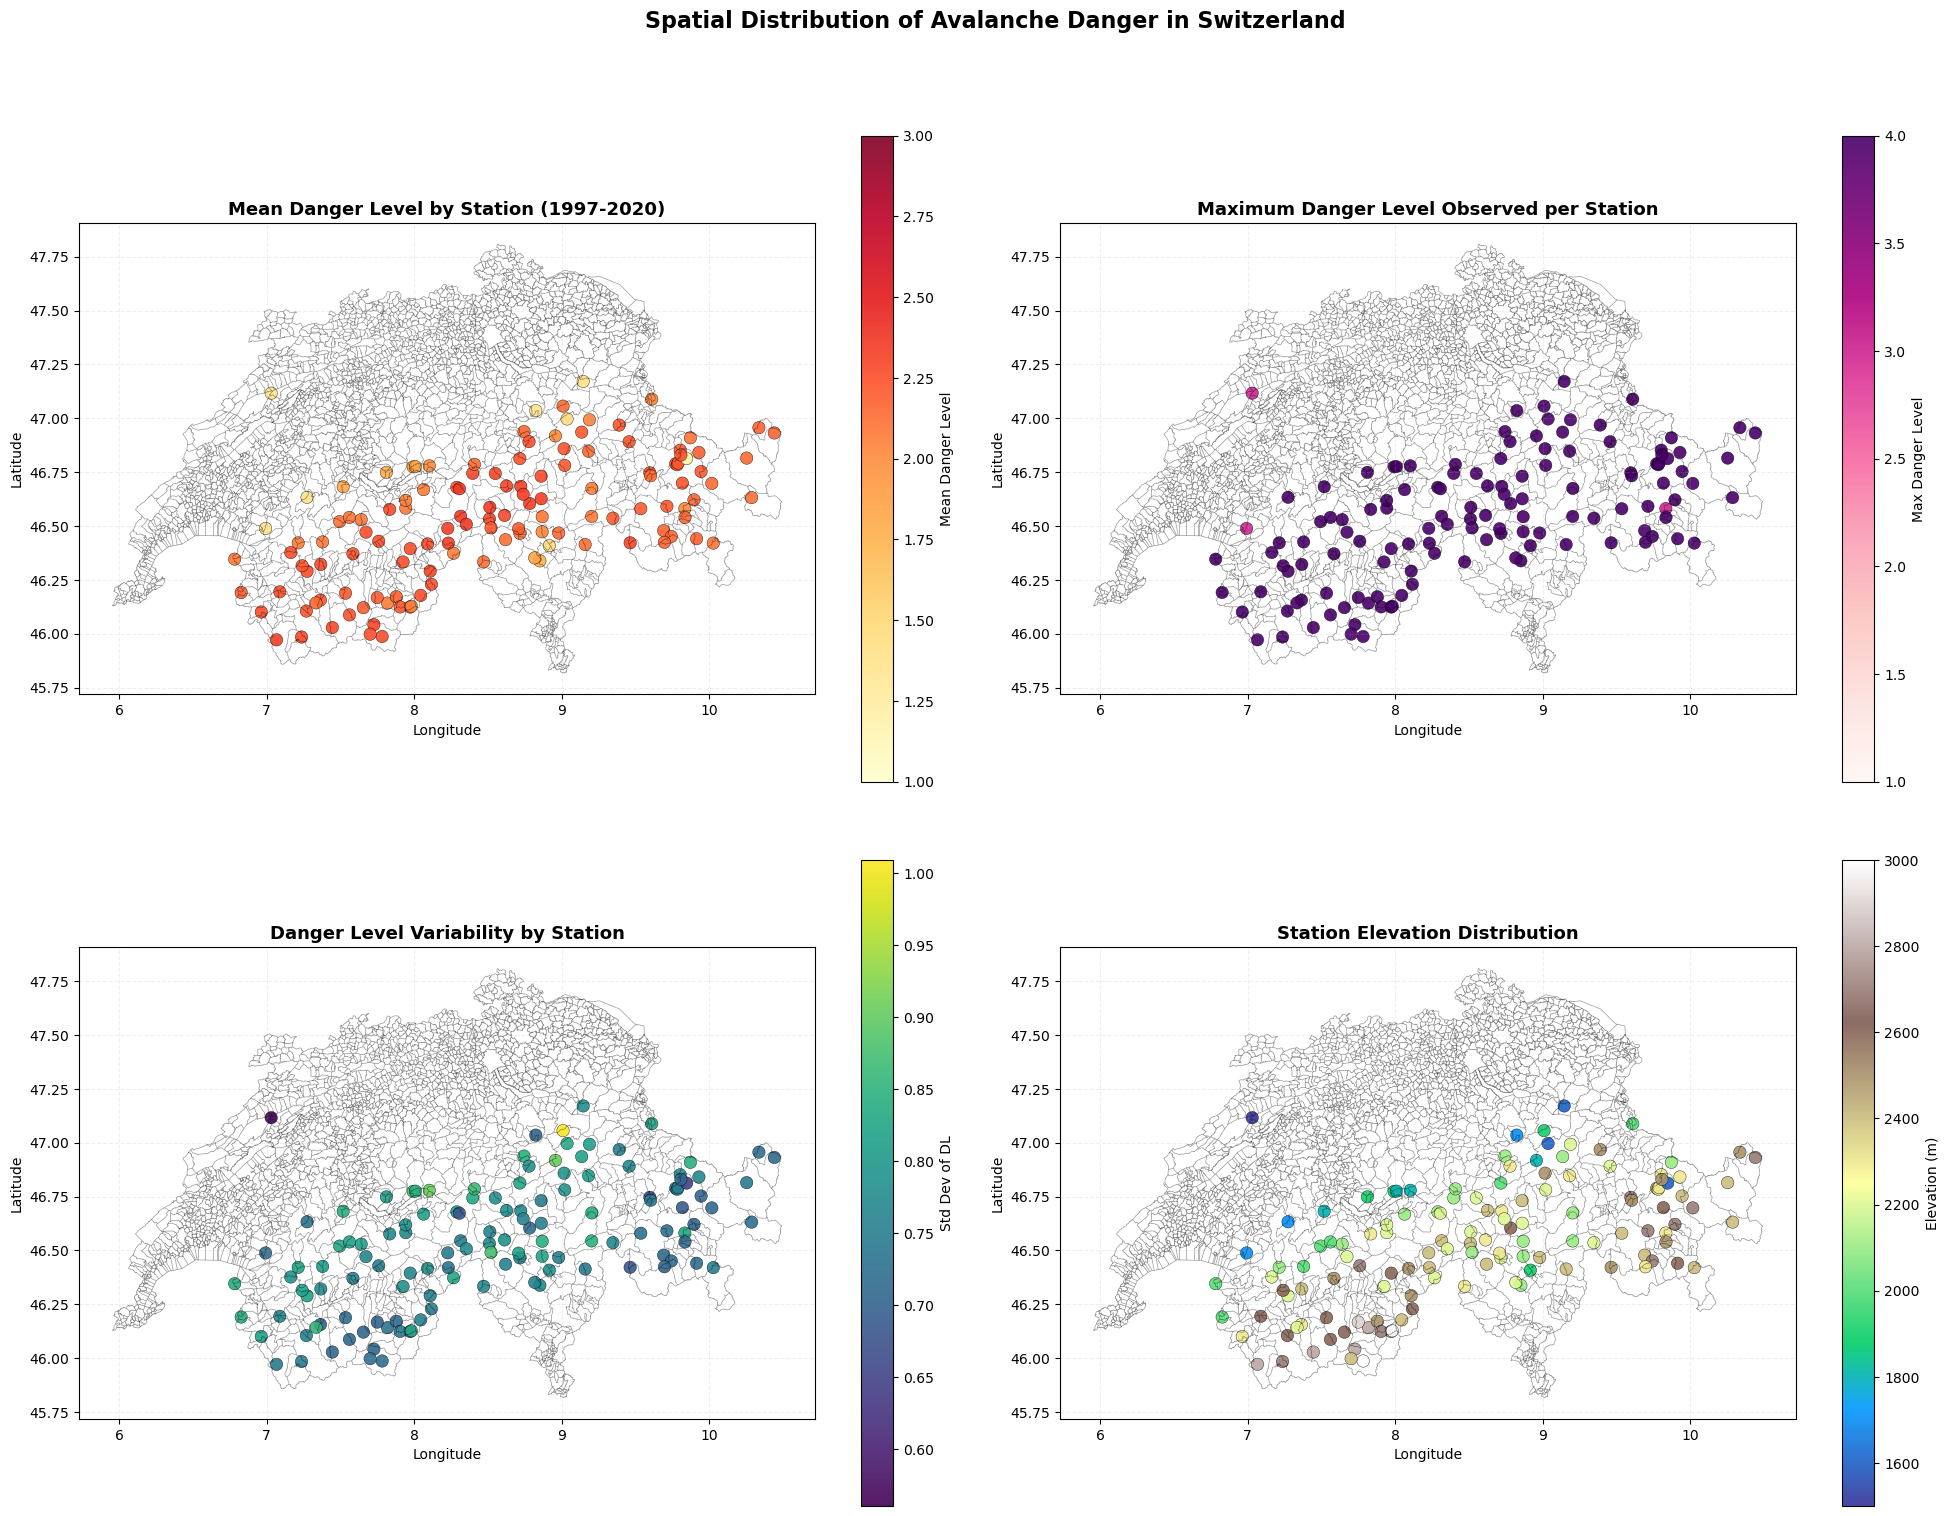

In [10]:
# Spatial Distribution of Danger Levels

import warnings
warnings.filterwarnings('ignore')

# Load Swiss boundaries
try:
    swiss_bounds = gpd.read_file('data/swissboundaries.gpkg')
    print(f"✅ Swiss boundaries loaded: {len(swiss_bounds)} features")
    print(f"   CRS: {swiss_bounds.crs}")
    
    # Ensure it's in WGS84 for compatibility with lat/lon
    if swiss_bounds.crs != 'EPSG:4326':
        swiss_bounds = swiss_bounds.to_crs('EPSG:4326')
        print("   Reprojected to EPSG:4326")
except Exception as e:
    print(f"⚠️ Could not load Swiss boundaries: {e}")
    print("   Maps will display without background")
    swiss_bounds = None

# Create station statistics
station_stats = imis_df.groupby('station_code').agg({
    'dangerLevel': ['mean', 'std', 'max', 'count'],
    'lon': 'first',
    'lat': 'first',
    'elevation_station': 'first',
    'warnreg': 'first'
}).reset_index()

# Flatten column names
station_stats.columns = ['station_code', 'mean_DL', 'std_DL', 'max_DL', 'n_obs', 
                          'lon', 'lat', 'elevation', 'warnreg']

# Remove any stations with missing coordinates
station_stats = station_stats.dropna(subset=['lon', 'lat'])

print(f"\nTotal stations with coordinates: {len(station_stats)}")

# === SPATIAL VISUALIZATIONS WITH MAP ===
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Spatial Distribution of Avalanche Danger in Switzerland', 
             fontsize=16, fontweight='bold', y=0.995)

# 1a. Mean Danger Level by Station
ax1 = axes[0, 0]
if swiss_bounds is not None:
    swiss_bounds.plot(ax=ax1, color='black', edgecolor='white', linewidth=0.5, alpha=0.4)
scatter1 = ax1.scatter(
    station_stats.lon, station_stats.lat,
    c=station_stats.mean_DL, cmap='YlOrRd',
    s=80, edgecolor='black', linewidth=0.3, alpha=0.9,
    vmin=1, vmax=3
)
plt.colorbar(scatter1, ax=ax1, shrink=0.8, label='Mean Danger Level')
ax1.set_title('Mean Danger Level by Station (1997-2020)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid(True, alpha=0.2, linestyle='--')

# 1b. Maximum Danger Level by Station
ax2 = axes[0, 1]
if swiss_bounds is not None:
    swiss_bounds.plot(ax=ax2, color='black', edgecolor='white', linewidth=0.5, alpha=0.4)
scatter2 = ax2.scatter(
    station_stats.lon, station_stats.lat,
    c=station_stats.max_DL, cmap='RdPu',
    s=80, edgecolor='black', linewidth=0.3, alpha=0.9,
    vmin=1, vmax=4
)
plt.colorbar(scatter2, ax=ax2, shrink=0.8, label='Max Danger Level')
ax2.set_title('Maximum Danger Level Observed per Station', fontsize=13, fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.grid(True, alpha=0.2, linestyle='--')

# 1c. Danger Level Variability (Std Dev)
ax3 = axes[1, 0]
if swiss_bounds is not None:
    swiss_bounds.plot(ax=ax3, color='black', edgecolor='white', linewidth=0.5, alpha=0.4)
scatter3 = ax3.scatter(
    station_stats.lon, station_stats.lat,
    c=station_stats.std_DL, cmap='viridis',
    s=80, edgecolor='black', linewidth=0.3, alpha=0.9
)
plt.colorbar(scatter3, ax=ax3, shrink=0.8, label='Std Dev of DL')
ax3.set_title('Danger Level Variability by Station', fontsize=13, fontweight='bold')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.grid(True, alpha=0.2, linestyle='--')

# 1d. Elevation-Coded Stations
ax4 = axes[1, 1]
if swiss_bounds is not None:
    swiss_bounds.plot(ax=ax4, color='black', edgecolor='white', linewidth=0.5, alpha=0.4)
scatter4 = ax4.scatter(
    station_stats.lon, station_stats.lat,
    c=station_stats.elevation, cmap='terrain',
    s=80, edgecolor='black', linewidth=0.3, alpha=0.9
)
plt.colorbar(scatter4, ax=ax4, shrink=0.8, label='Elevation (m)')
ax4.set_title('Station Elevation Distribution', fontsize=13, fontweight='bold')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
ax4.grid(True, alpha=0.2, linestyle='--')

plt.tight_layout()
plt.show()

# ...existing code for regional analysis...

### **2.2 Meteorological Drivers of Instability**
The "Big Drivers" Boxplots: Create boxplots of key meteorological variables grouped by dangerLevel.

HN72_24 (3-day new snow): Should show a very strong positive correlation with DL.

VW (Wind): Should be higher for DL3/4 (drifting snow problem).

TA (Air Temp): Might show a complex relationship (danger can be high when very cold or very warm).

Stability Index Validation: Boxplots of your imputed stability indices (Sn, ccl_pwl, etc.) by dangerLevel.

Expectation: These should decrease as danger increases.

Sanity Check: Do the imputed values (6.0 or 4.0) correctly cluster in DL1/DL2?

### **2.3 Spatial Dependencies & Patterns**

This is unique to your project. You need to prove that spatial context matters.

Elevation Dependency: Scatter plot (or 2D histogram) of elevation_station vs. dangerLevel.

Goal: Confirm that higher elevations generally see higher danger.

The delta_elevation check: Boxplot of your new delta_elevation feature by dangerLevel.

Expectation: DL3 and DL4 should have mostly positive delta_elevation values. DL1 should be mixed.

Spatial Autocorrelation (Visual): Plot the station values for a single high-danger day on a map.

Why? Do you see clusters of red (DL4)? Or is it random noise? A CNN relies on these clusters existing.

### **2.4 Seasonal Trends and Autocorrelation**

Avalanche danger is path-dependent; it depends on what happened yesterday and last week.

Time Series visualization: Plot dangerLevel, HN24 (daily snow), and HS_mod (total snow) together for one major station (e.g., Weissfluhjoch WFJ2) over one full winter season.

Goal: See if spikes in HN24 immediately precede spikes in dangerLevel.

Persistence check: What is the probability that today's danger level is the same as yesterday's?

Why? A "naive" model that just predicts yesterday's value is surprisingly hard to beat. You need to know this baseline accuracy.

### **2.5 Multicollinearity Analysis**